## Analyzing OpenTransit Bus Location Data - Average Wait Time

This notebook presents an example of working with the bus arrival data. We'll take the bus arrivals from routes 1 and 14 and examine the wait times at each stop on each route.

In [33]:
import json

from datetime import datetime, timedelta, timezone, time, date

import pandas as pd
import numpy as np

In [34]:
%matplotlib inline

## Load the Data

In [35]:
def load_json(filename = 'sample_routes_stops_15s.json'):
    with open(filename, 'r') as f:
        return json.load(f)

In [36]:
test = pd.DataFrame(load_json()).drop(labels = 'index', axis = 'columns')

In [37]:
test.sample(10)

,DID,ROUTE,SID,TIME,VID
17649,14___O_F00,14,5614,1539666461000,7249
8924,1____I_F00,1,4016,1539617425000,5545
1459,1____O_F00,1,6315,1539621146000,5566
10920,1____I_F00,1,4025,1539641913000,5638
23706,14___I_F00,14,5336,1539656723000,7256
6441,1____O_F00,1,3839,1539626233000,5553
13122,1____I_F00,1,3887,1539621626000,5528
17123,14___O_F00,14,5626,1539663040000,7214
6265,1____O_F00,1,3837,1539659859000,5625
3505,1____O_F00,1,6295,1539643383000,5505


## Computing Wait Times

Our goal is to compute the average wait time, at a stop on a route, over a given period of time. We'll do this in two steps:

- Compute the wait time at a stop for every minute in the given timespan
- Average over these wait times

In [38]:
# find the smallest nonnegative waiting time
def absmin(series):
    return series[series >= 0].min()

# finds the wait times for data from a single day
def get_daily_wait_times(df, start_time, end_time, group):
    minute_range = [start_time + timedelta(minutes=i) for i in range(
        (end_time - start_time).seconds//60)]
    wait_times = pd.DataFrame(columns=[])

    for minute in minute_range:
        # TODO (jtanquil): we get this error, see if you can fix it
        # A value is trying to be set on a copy of a slice from a DataFrame.
        # Try using .loc[row_indexer,col_indexer] = value instead
        # See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
        #   df['WAIT'] = df['timestamp'].apply(lambda x: (x - minute).total_seconds())
        df['WAIT'] = df['TIME'].apply(lambda x: (x - minute).total_seconds())
        pivot = df[group + ['WAIT']].pivot_table(values = ['WAIT'], index = group, aggfunc = absmin)
        pivot['TIME'] = minute
        pivot = pivot.reset_index()
        wait_times = wait_times.append(pivot, sort = True)

    return wait_times

def get_all_wait_times(df, timespan = ("00:00", "23:59"), group = ['ROUTE']): #probably restrict timespan to when buses are actually running
    # process arrivals df
    arrivals = df.copy(deep = True)
    arrivals['TIME'] = arrivals['TIME'].apply(lambda x: datetime.fromtimestamp(x/1000, timezone(timedelta(hours = -8))))
    arrivals['DATE'] = arrivals['TIME'].apply(lambda x: x.date())
    
    dates = arrivals['DATE'].unique()
    avg_over_pd = pd.DataFrame(columns = group + ['DATE', 'TIME', 'WAIT'])

    for date in dates:
        #print(f"{datetime.now().strftime('%a %b %d %I:%M:%S %p')}: start processing {date}.")
        start_time = datetime.strptime(f"{date.isoformat()} {timespan[0]} -0800", "%Y-%m-%d %H:%M %z")
        end_time   = datetime.strptime(f"{date.isoformat()} {timespan[1]} -0800", "%Y-%m-%d %H:%M %z")
        daily_wait = get_daily_wait_times(arrivals[arrivals['DATE'] == date], start_time, end_time, group)
        #print(f"{datetime.now().strftime('%a %b %d %I:%M:%S %p')}: found waits for {date}.")
        #daily_wait = daily_wait.pivot_table(values = ['WAIT'], index = group).reset_index()
        daily_wait['DATE'] = date
        daily_wait['TIME'] = daily_wait['TIME'].apply(lambda x: x.time())
        avg_over_pd = avg_over_pd.append(daily_wait, sort = True)

    return avg_over_pd

These functions, together, will return a DataFrame containing the wait times for every minute over the given time period. The `group` parameter allows us to aggregate wait times by certain properties - for instance, if we want to get all of the wait times for each stop of each route, we'll need to aggregate the arrivals by `SID` and `ROUTE`. 

With this DataFrame, we can compute the average wait time, in addition to any other summary statistics we want:

In [39]:
def quantiles(series):
    return [np.percentile(series, i) for i in [5, 25, 50, 75, 95]]

def get_summary_statistics(df, group):
    waits = df.pivot_table(values = ['WAIT'], index = group, aggfunc = {'WAIT': [np.mean, np.std, quantiles]}).reset_index()
    waits.columns = ['_'.join(col) if col[0] == 'WAIT' else ''.join(col) for col in waits.columns.values]
    waits[[f"{i}th percentile" for i in [5, 25, 50, 75, 95]]] = waits['WAIT_quantiles'].apply(lambda x: pd.Series(x))
    waits = waits.drop('WAIT_quantiles', axis = 1)
    return waits

In [40]:
def get_avg_wait_times(df, timespan = ("05:00", "23:59"), group = ['ROUTE']): # defaulting to muni operating hours
    return get_summary_statistics(get_all_wait_times(df, timespan, group), group)

In [41]:
avg_wait_times = get_avg_wait_times(test, timespan = ("08:00", "17:00"), group = ['ROUTE', 'SID'])

C:\Users\jose\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [42]:
avg_wait_times.sample(10)

,ROUTE,SID,WAIT_mean,WAIT_std,5th percentile,25th percentile,50th percentile,75th percentile,95th percentile
67,1,6291,19041.674074,19941.237348,30.00,203.75,11349.5,37829.0,50777.0
181,14,5836,19235.647222,19900.776850,87.95,407.75,11668.0,37979.0,50927.0
111,14,5540,19157.470370,19832.896418,89.95,419.00,11593.0,37829.0,50777.0
73,1,6298,19046.825926,19936.450638,29.00,206.00,11357.0,37829.0,50777.0
76,1,6301,19237.904630,20124.238140,30.00,205.00,11574.5,38219.0,51167.0
178,14,5628,19483.237037,20190.729742,75.00,364.00,11986.0,38534.0,51482.0
112,14,5541,19605.413889,20288.282058,62.95,362.75,12129.0,38759.0,51707.0
164,14,5609,19263.840741,19916.917293,88.00,406.75,11859.5,38024.0,50972.0
157,14,5600,19447.814815,20083.009265,88.00,424.75,12010.0,38384.0,51332.0
151,14,5594,19520.608333,20141.957633,89.95,421.75,12107.5,38519.0,51467.0


Finally, the wait times themselves can be useful for analysis and visualization.

In [43]:
waits = get_all_wait_times(test, timespan = ("08:00", "17:00"), group = ['ROUTE', 'SID'])

C:\Users\jose\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [44]:
waits.sample(10)

,DATE,ROUTE,SID,TIME,WAIT
131,2018-10-14,14,5568,11:17:00,43004.0
163,2018-10-14,14,5608,12:35:00,38159.0
102,2018-10-14,14,5531,08:54:00,52080.0
131,2018-10-14,14,5568,09:12:00,50504.0
126,2018-10-15,14,5561,08:07:00,85.0
128,2018-10-14,14,5565,13:42:00,33644.0
104,2018-10-15,14,5533,16:54:00,336.0
141,2018-10-15,14,5582,14:51:00,994.0
166,2018-10-15,14,5613,09:51:00,87.0
114,2018-10-15,14,5543,10:42:00,134.0


In [45]:
waits.describe()

,WAIT
count,203040.000000
mean,19363.318435
std,20134.460518
min,0.000000
25%,270.000000
50%,11822.000000
75%,38372.750000
max,55935.000000


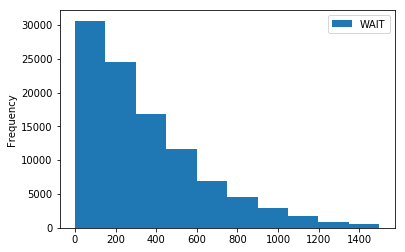

In [46]:
waits[waits['WAIT'] < 1500].plot.hist()